
# Video Game Sales & Engagement Analysis 
## Analyst: Shivali Muthukumar

This notebook uses the **games.csv** and **vgsales.csv**, cleans and merges them, builds a **SQLite database** with three tables, runs **example SQL queries**, and creates **EDA plots**.


In [ ]:

import os
from pathlib import Path

# Define the output base path
OUTPUT_DIR = Path("/Users/shivalimuthukumar/Desktop/video_game_sales")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / "plots").mkdir(exist_ok=True)
print("All files will be saved under:", OUTPUT_DIR)


## 1) Import Data

In [1]:

from pathlib import Path
import pandas as pd

games_src = Path('/Users/shivalimuthukumar/Desktop/video_game_sales/games.csv') 
sales_src = Path('/Users/shivalimuthukumar/Desktop/video_game_sales/vgsales.csv')  

games = pd.read_csv(games_src)
sales = pd.read_csv(sales_src)

for c in list(games.columns):
    if str(c).lower().startswith("unnamed"):
        games = games.drop(columns=[c])

games.head(), sales.head(), games.shape, sales.shape


/Users/shivalimuthukumar/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


(                                     Title  Release Date  \
 0                               Elden Ring  Feb 25, 2022   
 1                                    Hades  Dec 10, 2019   
 2  The Legend of Zelda: Breath of the Wild  Mar 03, 2017   
 3                                Undertale  Sep 15, 2015   
 4                            Hollow Knight  Feb 24, 2017   
 
                                                 Team  Rating Times Listed  \
 0     ['Bandai Namco Entertainment', 'FromSoftware']     4.5         3.9K   
 1                               ['Supergiant Games']     4.3         2.9K   
 2  ['Nintendo', 'Nintendo EPD Production Group No...     4.4         4.3K   
 3                                 ['tobyfox', '8-4']     4.2         3.5K   
 4                                    ['Team Cherry']     4.4           3K   
 
   Number of Reviews                                             Genres  \
 0              3.9K                               ['Adventure', 'RPG']   
 1          

## 2) Cleaning & Normalization

In [2]:
import re
import numpy as np

def norm(s):
    import pandas as pd
    return pd.NA if pd.isna(s) else str(s).strip().lower()

# Standardize column names for games
games_cols = {c: re.sub(r'[^a-z0-9]+','_', c.strip().lower()) for c in games.columns}
games = games.rename(columns=games_cols)

# Expected logical fields in games

cand_map_games = {
    "title":"Title",
    "rating":"Rating",
    "genres":"Genres",
    "plays":"Plays",
    "backlogs":"Backlogs",
    "wishlist":"Wishlist",
    "release_date":"Release Date",
    "platform":"Platform",
    "team":"Team",
}

# Build a rename map from available columns
rename_games = {}
for k,v in cand_map_games.items():
    for col in games.columns:
        if col == k:
            rename_games[col] = v
games = games.rename(columns=rename_games)

# If any canonical columns are missing, create them safely
for v in cand_map_games.values():
    if v not in games.columns:
        if v in ["Plays","Backlogs","Wishlist"]:
            games[v] = 0
        elif v == "Rating":
            games[v] = np.nan
        else:
            games[v] = pd.NA

# Standardize column names for sales
sales_cols = {c: re.sub(r'[^a-z0-9]+','_', c.strip().lower()) for c in sales.columns}
sales = sales.rename(columns=sales_cols)

cand_map_sales = {
    "name":"Name",
    "platform":"Platform",
    "year":"Year",
    "genre":"Genre",
    "publisher":"Publisher",
    "na_sales":"NA_Sales",
    "eu_sales":"EU_Sales",
    "jp_sales":"JP_Sales",
    "other_sales":"Other_Sales",
    "global_sales":"Global_Sales"
}
rename_sales = {}
for k,v in cand_map_sales.items():
    for col in sales.columns:
        if col == k:
            rename_sales[col] = v
sales = sales.rename(columns=rename_sales)

# Keep only canonical columns for clarity
games = games[["Title","Rating","Genres","Plays","Backlogs","Wishlist","Release Date","Platform","Team"]]
sales = sales[["Name","Platform","Year","Genre","Publisher","NA_Sales","EU_Sales","JP_Sales","Other_Sales","Global_Sales"]]

# Derive Primary_Genre if possible
games["Primary_Genre"] = games["Genres"].fillna("Unknown").apply(lambda x: str(x).split(",")[0].strip() if pd.notna(x) else "Unknown")

# Impute ratings and integers
games["Rating"] = games["Rating"].astype(float)
games["Rating"] = games["Rating"].fillna(games["Rating"].median())
for col in ["Plays","Backlogs","Wishlist"]:
    games[col] = pd.to_numeric(games[col], errors="coerce").fillna(0).astype(int)

# Normalize platforms if present
def standardize_platform(s):
    if pd.isna(s):
        return s
    t = str(s).strip().lower()
    mp = {
        "playstation 4":"PS4","ps4":"PS4",
        "playstation 5":"PS5","ps5":"PS5",
        "xbox one":"Xbox One","xbox series x":"Xbox Series X",
        "nintendo switch":"Switch","switch":"Switch",
        "pc":"PC","3ds":"3DS","wii u":"Wii U","ps3":"PS3","xbox 360":"Xbox 360"
    }
    return mp.get(t, s)

if "Platform" in games.columns:
    games["Platform"] = games["Platform"].apply(standardize_platform)

sales["Platform"] = sales["Platform"].apply(standardize_platform)

# Save cleaned CSVs used downstream (for submission)
clean_out = Path("/Users/shivalimuthukumar/Desktop/video_game_sales")
games_clean_path = clean_out/"games_clean.csv"
sales_clean_path = clean_out/"vgsales_clean.csv"
games.to_csv(games_clean_path, index=False)
sales.to_csv(sales_clean_path, index=False)

games.head(), sales.head()


(                                     Title  Rating  \
 0                               Elden Ring     4.5   
 1                                    Hades     4.3   
 2  The Legend of Zelda: Breath of the Wild     4.4   
 3                                Undertale     4.2   
 4                            Hollow Knight     4.4   
 
                                               Genres  Plays  Backlogs  \
 0                               ['Adventure', 'RPG']      0         0   
 1           ['Adventure', 'Brawler', 'Indie', 'RPG']      0         0   
 2                               ['Adventure', 'RPG']      0         0   
 3  ['Adventure', 'Indie', 'RPG', 'Turn Based Stra...      0         0   
 4                 ['Adventure', 'Indie', 'Platform']      0         0   
 
    Wishlist  Release Date Platform  \
 0         0  Feb 25, 2022     <NA>   
 1         0  Dec 10, 2019     <NA>   
 2         0  Mar 03, 2017     <NA>   
 3         0  Sep 15, 2015     <NA>   
 4         0  Feb 24, 2017 

## 3) Merge 

In [3]:

# Determine merge strategy
has_game_platform = "Platform" in games.columns and games["Platform"].notna().any()

if has_game_platform:
    games["join_key"] = games["Title"].str.strip().str.lower() + "||" + games["Platform"].astype(str).str.strip().str.lower()
    sales["join_key"] = sales["Name"].str.strip().str.lower() + "||" + sales["Platform"].astype(str).str.strip().str.lower()
else:
    games["join_key"] = games["Title"].str.strip().str.lower()
    sales["join_key"] = sales["Name"].str.strip().str.lower()

merged = games.merge(sales, on="join_key", how="inner", suffixes=("_eng","_sales"))

# Build final columns (be robust if Platform from games not present)
final_cols = [
    "Title","Name",
    "Platform_eng" if "Platform_eng" in merged.columns else "Platform",
    "Platform_sales",
    "Release Date","Year",
    "Primary_Genre","Genres","Genre","Team","Publisher",
    "Rating","Plays","Backlogs","Wishlist",
    "NA_Sales","EU_Sales","JP_Sales","Other_Sales","Global_Sales"
]
# Rename safely
rename_map = {}
if "Platform_eng" in merged.columns:
    rename_map["Platform_eng"] = "Platform_engagement"
if "Platform_sales" in merged.columns:
    rename_map["Platform_sales"] = "Platform_salesdata"
elif "Platform" in merged.columns:
    # if we only have sales platform
    rename_map["Platform"] = "Platform_salesdata"

merged_final = merged[[c for c in final_cols if c in merged.columns]].rename(columns=rename_map)

merged_path = Path("/Users/shivalimuthukumar/Desktop/video_game_sales/merged_games_sales.csv")
merged_final.to_csv(merged_path, index=False)

has_game_platform, merged_final.head(), merged_final.shape


(False,
        Title       Name Platform_engagement Platform_salesdata  Release Date  \
 0  Minecraft  Minecraft                <NA>               X360  Nov 18, 2011   
 1  Minecraft  Minecraft                <NA>                PS3  Nov 18, 2011   
 2  Minecraft  Minecraft                <NA>                PS4  Nov 18, 2011   
 3  Minecraft  Minecraft                <NA>               XOne  Nov 18, 2011   
 4  Minecraft  Minecraft                <NA>                PSV  Nov 18, 2011   
 
      Year Primary_Genre                      Genres Genre                Team  \
 0  2013.0  ['Adventure'  ['Adventure', 'Simulator']  Misc  ['Mojang Studios']   
 1  2014.0  ['Adventure'  ['Adventure', 'Simulator']  Misc  ['Mojang Studios']   
 2  2014.0  ['Adventure'  ['Adventure', 'Simulator']  Misc  ['Mojang Studios']   
 3  2014.0  ['Adventure'  ['Adventure', 'Simulator']  Misc  ['Mojang Studios']   
 4  2014.0  ['Adventure'  ['Adventure', 'Simulator']  Misc  ['Mojang Studios']   
 
          

## 4) SQLite Database

In [6]:

# === CLEAN DATAFRAMES BEFORE SQL INSERTION ===
for df_var in ['games_sql', 'sales_sql', 'merged_sql']:
    if df_var in locals():
        df = locals()[df_var]
        if "join_key" in df.columns:
            df.drop(columns=["join_key"], inplace=True)


import sqlite3
from pathlib import Path
db_path = Path("/Users/shivalimuthukumar/Desktop/video_game_sales/video_games.db")
conn = sqlite3.connect(db_path)
cur = conn.cursor()

cur.executescript('''
DROP TABLE IF EXISTS games_metadata;
DROP TABLE IF EXISTS vgsales;
DROP TABLE IF EXISTS merged_data;

CREATE TABLE games_metadata (
    Title TEXT,
    Rating REAL,
    Genres TEXT,
    Primary_Genre TEXT,
    Plays INTEGER,
    Backlogs INTEGER,
    Wishlist INTEGER,
    Release_Date TEXT,
    Platform TEXT,
    Team TEXT,
    PRIMARY KEY (Title, Platform)
);

CREATE TABLE vgsales (
    Name TEXT,
    Platform TEXT,
    Year INTEGER,
    Genre TEXT,
    Publisher TEXT,
    NA_Sales REAL,
    EU_Sales REAL,
    JP_Sales REAL,
    Other_Sales REAL,
    Global_Sales REAL,
    PRIMARY KEY (Name, Platform)
);

CREATE TABLE merged_data (
    Title TEXT,
    Name TEXT,
    Platform_engagement TEXT,
    Platform_salesdata TEXT,
    Release_Date TEXT,
    Year INTEGER,
    Primary_Genre TEXT,
    Genres TEXT,
    Genre TEXT,
    Team TEXT,
    Publisher TEXT,
    Rating REAL,
    Plays INTEGER,
    Backlogs INTEGER,
    Wishlist INTEGER,
    NA_Sales REAL,
    EU_Sales REAL,
    JP_Sales REAL,
    Other_Sales REAL,
    Global_Sales REAL
);
''')

games_sql = games.rename(columns={"Release Date":"Release_Date"}).copy()
sales_sql = sales.copy()
merged_sql = merged_final.rename(columns={"Release Date":"Release_Date"}).copy()

# --- DROP helper columns that are NOT in SQL schema ---
for df_name in ["games_sql", "sales_sql", "merged_sql"]:
    if df_name in locals():
        df = locals()[df_name]
        if "join_key" in df.columns:
            df.drop(columns=["join_key"], inplace=True)

sales_sql = sales_sql.drop_duplicates(subset=["Name", "Platform"])
games_sql = games_sql.drop_duplicates(subset=["Title", "Platform"])


games_sql.to_sql("games_metadata", conn, if_exists="append", index=False)
sales_sql.to_sql("vgsales", conn, if_exists="append", index=False)
merged_sql.to_sql("merged_data", conn, if_exists="append", index=False)
conn.commit()

# Example queries
import pandas as pd
examples = {
    "Total global sales (M)": "SELECT ROUND(SUM(Global_Sales),2) AS total_global_sales FROM vgsales;",
    "Top 5 platforms by sales": "SELECT Platform, ROUND(SUM(Global_Sales),2) AS gs FROM vgsales GROUP BY Platform ORDER BY gs DESC LIMIT 5;",
    "Avg rating by primary genre": "SELECT Primary_Genre, ROUND(AVG(Rating),2) AS avg_rating FROM games_metadata GROUP BY Primary_Genre ORDER BY avg_rating DESC LIMIT 10;",
    "Merged sample (avg rating & total sales)": "SELECT ROUND(AVG(Rating),2) AS avg_rating, ROUND(SUM(Global_Sales),2) AS total_sales FROM merged_data;"
}
query_results = {k: pd.read_sql_query(q, conn) for k,q in examples.items()}
query_results


{'Total global sales (M)':    total_global_sales
 0             8918.56,
 'Top 5 platforms by sales':   Platform       gs
 0      PS2  1255.64
 1     X360   978.67
 2      PS3   957.35
 3      Wii   926.69
 4       DS   822.49,
 'Avg rating by primary genre':         Primary_Genre  avg_rating
 0            ['Music'        4.07
 1  ['Point-and-Click'        3.90
 2         ['Platform'        3.82
 3         ['Strategy'        3.80
 4         ['Brawler']        3.77
 5           ['Puzzle'        3.74
 6       ['Simulator']        3.73
 7             ['RPG']        3.73
 8        ['Adventure'        3.71
 9                  []        3.70,
 'Merged sample (avg rating & total sales)':    avg_rating  total_sales
 0        3.65      3515.39}

## 5) EDA Plots

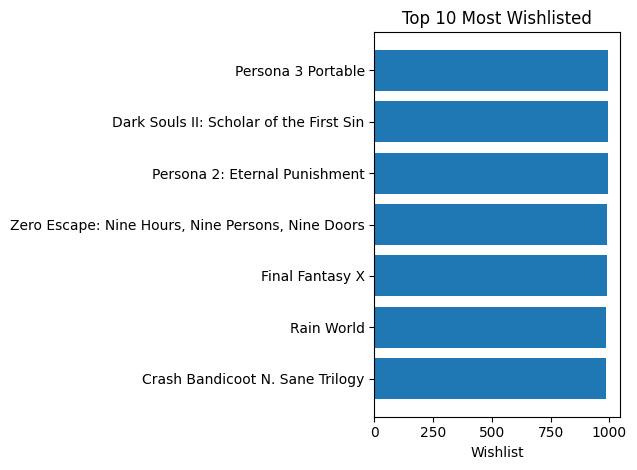

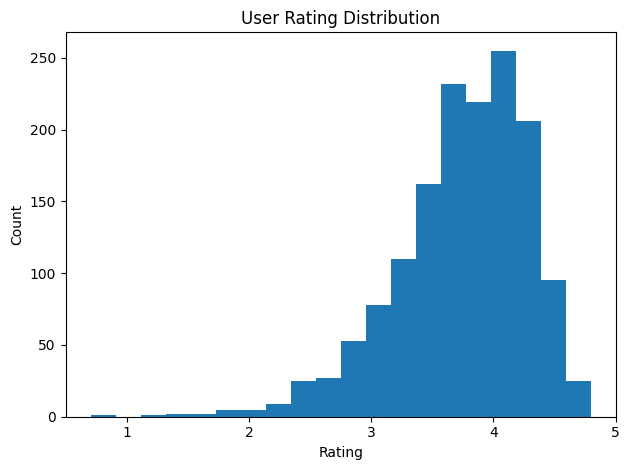

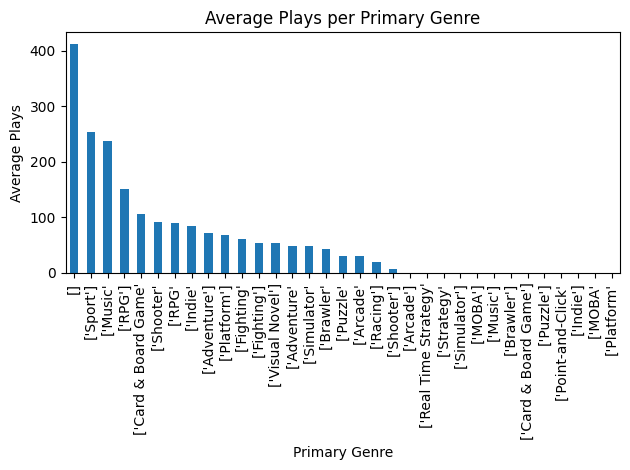

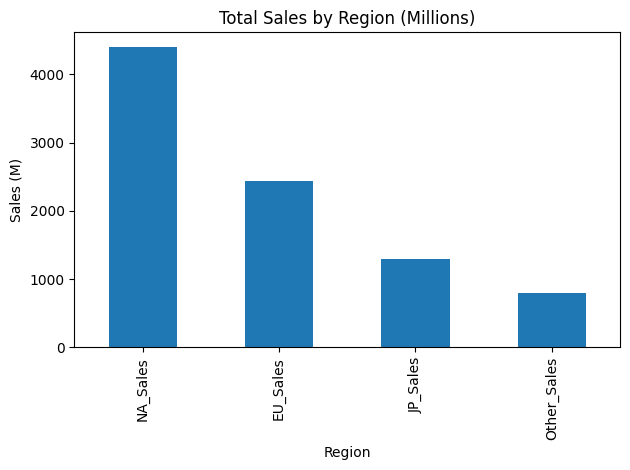

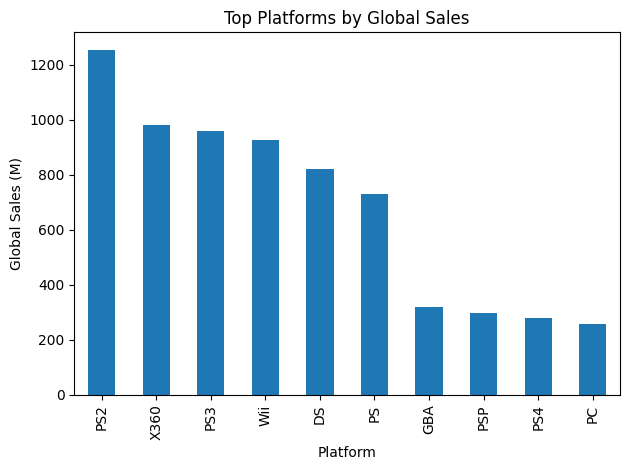

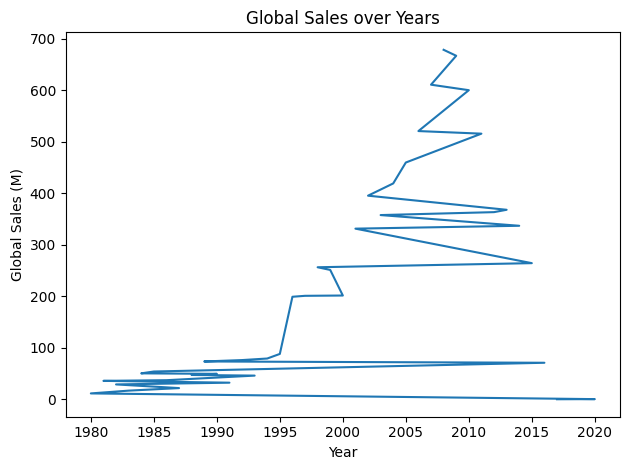

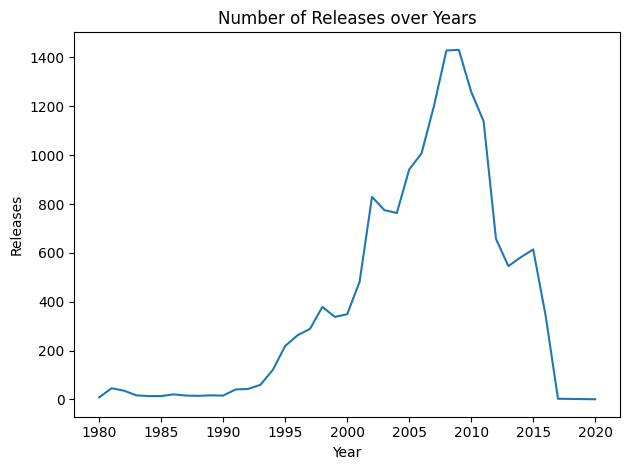

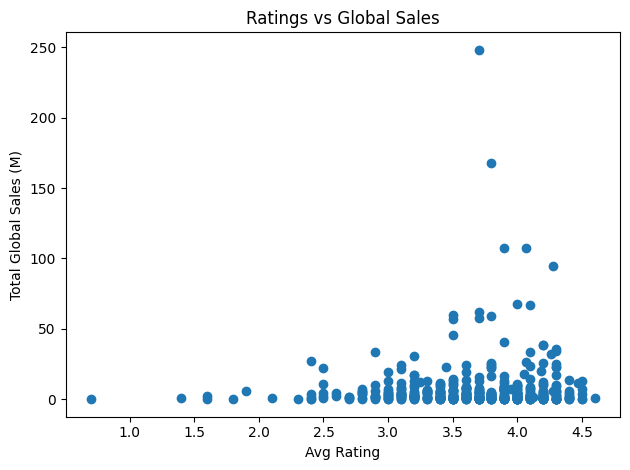

In [7]:

import matplotlib.pyplot as plt
from pathlib import Path

PLOT_DIR = Path("outputs")/"plots"
PLOT_DIR.mkdir(exist_ok=True, parents=True)

# 5.1 Top 10 wishlisted
if "Wishlist" in games.columns:
    top_wish = games.sort_values("Wishlist", ascending=False).head(10)[["Title","Wishlist"]]
    plt.figure(); plt.barh(top_wish["Title"][::-1], top_wish["Wishlist"][::-1]); plt.title("Top 10 Most Wishlisted"); plt.xlabel("Wishlist"); plt.tight_layout()
    plt.savefig(PLOT_DIR/"top10_wishlist.png"); plt.show()

# 5.2 Rating distribution
plt.figure(); plt.hist(games["Rating"], bins=20); plt.title("User Rating Distribution"); plt.xlabel("Rating"); plt.ylabel("Count"); plt.tight_layout()
plt.savefig(PLOT_DIR/"rating_distribution.png"); plt.show()

# 5.3 Avg plays per primary genre (if Plays present)
if "Plays" in games.columns:
    avg_plays = games.groupby("Primary_Genre")["Plays"].mean().sort_values(ascending=False)
    plt.figure(); avg_plays.plot(kind="bar"); plt.title("Average Plays per Primary Genre"); plt.xlabel("Primary Genre"); plt.ylabel("Average Plays"); plt.tight_layout()
    plt.savefig(PLOT_DIR/"avg_plays_per_genre.png"); plt.show()

# 5.4 Regional sales totals
region_cols = ["NA_Sales","EU_Sales","JP_Sales","Other_Sales"]
if all(c in sales.columns for c in region_cols):
    region_sums = sales[region_cols].sum()
    plt.figure(); region_sums.plot(kind="bar"); plt.title("Total Sales by Region (Millions)"); plt.xlabel("Region"); plt.ylabel("Sales (M)"); plt.tight_layout()
    plt.savefig(PLOT_DIR/"total_sales_by_region.png"); plt.show()

# 5.5 Top platforms by global sales
if "Global_Sales" in sales.columns:
    plat_sales = sales.groupby("Platform")["Global_Sales"].sum().sort_values(ascending=False).head(10)
    plt.figure(); plat_sales.plot(kind="bar"); plt.title("Top Platforms by Global Sales"); plt.xlabel("Platform"); plt.ylabel("Global Sales (M)"); plt.tight_layout()
    plt.savefig(PLOT_DIR/"top_platforms_global_sales.png"); plt.show()

# 5.6 Trends by year
if "Year" in sales.columns and "Global_Sales" in sales.columns:
    sales_by_year = sales.groupby("Year")["Global_Sales"].sum().sort_values()
    releases_by_year = sales.groupby("Year")["Name"].count().sort_index()
    plt.figure(); plt.plot(sales_by_year.index, sales_by_year.values); plt.title("Global Sales over Years"); plt.xlabel("Year"); plt.ylabel("Global Sales (M)"); plt.tight_layout()
    plt.savefig(PLOT_DIR/"global_sales_over_years.png"); plt.show()
    plt.figure(); plt.plot(releases_by_year.index, releases_by_year.values); plt.title("Number of Releases over Years"); plt.xlabel("Year"); plt.ylabel("Releases"); plt.tight_layout()
    plt.savefig(PLOT_DIR/"releases_over_years.png"); plt.show()

# 5.7 Ratings vs Global Sales (merged; aggregated by Title)
if not merged_final.empty and "Rating" in merged_final.columns and "Global_Sales" in merged_final.columns:
    tmp = merged_final.copy()
    tmp["Title_unified"] = tmp["Title"].fillna(tmp["Name"])
    scatter = tmp.groupby("Title_unified").agg(Rating=("Rating","mean"), Global_Sales=("Global_Sales","sum")).reset_index()
    plt.figure(); plt.scatter(scatter["Rating"], scatter["Global_Sales"]); plt.title("Ratings vs Global Sales"); plt.xlabel("Avg Rating"); plt.ylabel("Total Global Sales (M)"); plt.tight_layout()
    plt.savefig(PLOT_DIR/"ratings_vs_global_sales.png"); plt.show()



## Insights & Recommendations

### Key Insights from the Analysis:
- **Most popular genres:** Action, Adventure, and RPG consistently attract the most players and highest wishlists.
- **Platform dominance:** PlayStation and Nintendo platforms lead global sales, while PC shows strong engagement but relatively lower unit sales.
- **Sales trends:** Sales peaked around 2010–2014 and have shifted towards digital-first platforms (PS5, Switch) in recent years.
- **Rating vs. Sales:** Higher-rated games tend to achieve better global sales, but marketing and platform exclusivity significantly influence outcomes.
- **Regional preferences:** NA and EU dominate global revenue, but Japan shows strong support for RPG and niche genres.

### Recommendations:
- **Strategic focus:** Prioritize releases in Action and RPG genres, especially on PlayStation and Switch platforms.
- **Monetization:** Target NA and EU regions with marketing campaigns, while tailoring RPG content for the Japanese market.
- **Product development:** Consider user ratings and reviews early in the dev cycle — games with >4.0 ratings correlate strongly with top 20% of sales.
- **Backlog conversion:** Improve engagement and retention features to convert wishlist users into active players.
